# LLB parameter implementation

This code computes magnetization dynamics of a one-dimensional sample consisting of an arbitrary amaount of different mataerials with different parameters within. The equations for LLB and all said materials can be found below in documentation. Importantly, temperature dynamics for optical laser excitement are not included here, rather a temperature map on the same sample dimensions and an arbitrary amount of timesteps has to be imported. 

The code can be roughly seperated in four parts: 

The static part is merely the definition of the materials and samplestrucutre (things that only have to be computed once in the whole simulation): 

I. Defining the parameters for each consituent mateiral of the sample (section 1.1)

II. Creating a 1d sample of these constituents and mapping all parameters and functions that rely on them on the scale of the created sample structure (sections 1.2 and 1.3)

The dynamical part includes all temperature and magnetization dependence (things that have to be computed at every timestep):

III. Defining the temperature and magnetization dependence of the parameters (sections 2.2 and 2.3)

IV. Joining all predefined functions to run the simulation and create an output (section 2.5)

More detailed information on the steps and explanations for the subsections in between that have not been mentioned so far can be found below.

In [1]:
import numpy as np
from scipy import constants as sp
from scipy import optimize as op
from scipy import interpolate as ip
from matplotlib import pyplot as plt
import itertools
import time

For the attempt to solve the differential euqation with the integrated solver odeint we import two more modules:

In [2]:
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline

## (Magnetic) material class

I define a class that should compute and hold all the relevant parameters needed for the LLB computation. This class holds only material-specific parameters, while interactions between different materials should be defined and imported from the Structure class.

In [3]:
class material():
    def __init__(self, name, S, Tc, lamda, muat, kappa_anis, anis_axis, K_0, A_0, Ms, Delta):
        self.name=name                                      # name of the material used for the string representation of the class
        self.S=S                                            # effective spin
        self.Tc=Tc                                          # Curie temperature
        self.J=3*self.S/(self.S+1)*sp.k*self.Tc             # mean field exchange coupling constant
        self.mean_mag_map=create_mean_mag_map(self)         # creates the mean magnetization map over temperature as an interpolation function
        self.lamda=lamda                                    # intrinsic coupling to bath parameter
        self.muat=muat                                      # atomic magnetic moment in units of mu_Bohr
        self.kappa_anis=kappa_anis                          # exponent for the temperature dependence of uniaxial anisotropy
        self.anis_axis=anis_axis                            # uniaxials anisotropy axis (x:0, y:1, z:2) other anisotropies are not yet implemented 
        self.K_0=K_0                                        # value for the anisotropy at T=0 K in units of J/m^3
        self.A_0=A_0                                        # value for the exchange stiffness at T=0 K in units of J/m
        self.Ms=Ms                                          # value for the saturation magnetization at 0K in J/T/m^3
        self.Delta=Delta                                    # length of the grain in depth direction in m

In [4]:
    def __str__(self):
        return self.name

### Creation of the mean magnetization map

Here a temperature map of the mean field magnetization $m_{eq}(T)$ is created.
This means solving the self consistent equation

\begin{eqnarray}
    m_{eq}(T)&=&B_S(m_{eq}, T) \label{meq_def} \\
    B_S(m, T)&=& \frac{2 S+1}{2S} \coth{(\frac{2S+1}{2S}\frac{\text{self.}Jm}{k_BT})}-\frac{1}{2S} \coth{(\frac{1}{2S} \frac{\text{self.}Jm}{k_B T})} \label{Brillouin},
\end{eqnarray}

where

\begin{align}
\text{self.}J=3\frac{S}{S+1}k_B \ \text{self.}T_C
\end{align}

is the mean field exchange coupling constant for effective spin self.$S$ and Curie temperature self.$T_C$

In [5]:
    def create_mean_mag_map(self):
        # This function computes the mean field mean magnetization map by solving the self-consistent equation m=B(m, T)
        # As an output we get an interpolation function of the mean field magnetization at any temperature T<=T_c (this can of course be extended to T>T_c with zeros).

        # Start by defining a unity function m=m:
        def mag(m):
            return m

        # Define the Brillouin function as a function of scalars, as fsolve takes functions of scalars:
        def Brillouin(m, T):
            # This function takes input parameters
            #   (i) magnetization amplitude m_amp_grid (scalar)
            #   (ii) (electron) temperature (scalar)
            # As an output we get the Brillouin function evaluated at (i), (ii) (scalar)

            eta = self.J * m / sp.k / T /self.Tc
            c1 = (2 * self.S + 1) / (2 * self.S)
            c2 = 1 / (2 * self.S)
            bri_func = c1 / np.tanh(c1 * eta) - c2 / np.tanh(c2 * eta)
            return bri_func

        # Then we also need a temperature grid. I'll make it course grained for low temperatures (<0.8*Tc) (small slope) and fine grained for large temperatures (large slope):
        temp_grid=np.array(list(np.arange(0, 0.8, 1e-3))+list(np.arange(0.8, 1+1e-5, 1e-5)))

        # I will define the list of m_eq(T) here and append the solutions of m=B(m, T). It will have the length len(temp_grid) at the end.
        meq_list=[1.]

        # Define a function to find the intersection of m and B(m, T) for given T with scipy:
        def find_intersection_sp(m, Bm, m0):
            return op.fsolve(lambda x: m(x) - Bm(x), m0)

        # Find meq for every temperature, starting point for the search being (1-T/Tc)^(1/2), fill the list
        for i,T in enumerate(temp_grid[1:]):
            # Redefine the Brillouin function to set the temperature parameter (I did not find a more elegant solution to this):
            def Brillouin_2(m):
                return Brillouin(m, T)
            # Get meq:
            meq=find_intersection_sp(mag, Brillouin_2, np.sqrt(1-T))
            if meq[0]<0:            # This is a comletely unwarranted fix for values of meq<0 at temperatures very close to Tc, that fsolve produces. It seems to work though, as the interpolated function plotted by plot_mean_mags() seems clean.
                meq[0]*=-1
            # Append it to list me(T)
            meq_list.append(meq[0])
        meq_list[-1]=0              # This fixes slight computational errors to fix m_eq(Tc)=0 (it produces something like m_eq[-1]=1e-7)
        return ip.interp1d(temp_grid, meq_list)

### Creation of the map of derivative of the Brillouin function

To later define the longitudinal suszeptibility, we need to define the derivative of the Brillouin function.

\begin{align}
\frac{dB}{dx} = \frac{1}{4S^2\sinh^2(x/2S)}-\frac{(2S+1)^2}{4S^2\sinh^2(\frac{(2S+1)x}{2S})}, 
\end{align}

where $x=\frac{Jm}{k_BT}$.

The derivative will be evalueated at equilibrium $m=m_{eq}(T)$. In the following bit we will define the material-dependent prefactors of both terms.

In [6]:
    def dbrillouin_t1(self):
        return 1/4/self.S**2
    
    def dbrillouin_t2(self):
        return (2*self.S+1)**2/4/self.S**2

### Calling the mean field magnetization

In the __init()__ function, the maps of mean field magnetization and derivative of Brillouin function are called and saved with create_ functions. To call use these maps for any array of temperatures we define the get_ functions. 

In [7]:
    def get_mean_mag(self, T, tc_mask):
        # After creating the map, this function can be called to give m_eq at any temperature
        # The function takes a 1d-array of temperatures as an input (temperature map at each timestep) and returns an array with the respective mean field equilibrium magnetization
        meq=np.zeros(T.shape)
        meq[tc_mask]=self.mean_mag_map(T[tc_mask])
        return meq

### Material dependent parameters

#### Transverse and longitudinal damping parameters

Here we define the material dependent parameters of longitudinal and transversal damping parameters. Their dependence on temperature and mean magnetization will be added later when the sample structure is implemented:

\begin{eqnarray}
\alpha_{\parallel} &=&_{T<T_c} \frac{2\lambda}{S+1}\frac{1}{\sinh(2q_s)}\\
\alpha_{\perp} &=&_{T<T_c} \frac{\lambda}{m_{eq}(T)}(\frac{\tanh(q_s)}{q_s}-\frac{T}{3T_C}),
\end{eqnarray}

\begin{align}
\alpha_{\parallel, \perp} =_{T>T_c} \frac{2 \lambda}{3} \frac{T}{T_C}
\end{align}

where

\begin{align}
q_s=\frac{3 T_C m_{eq}(T)}{(2S+1)T}
\end{align}

$m_{eq}(T)$ is an argument of the function as get_mean_mag() will be called at every timestep before calling the functions for temperature dependent parameters.
As $q_s$ is temperature dependent, we will only compute this part later if a sample structure and the according mean field magnetization profile are created.

In [8]:
    def alpha_par(self):
        # This funtion computes the longitudinal damping parameter alpha_parallel
        return 2*self.lamda/(self.S+1)

    def qs(self):
        # This function computes the first term of the transverse damping parameter alpha_transverse
        qs=3*self.Tc/(2*self.S+1)
        return qs
    

#### Longitudinal Susceptibility

The longitudinal susceptibility in MFA is expressed as

\begin{align}
\chi_{\parallel}=_{T<T_C}\frac{\beta \mu_{\rm{at}} B_S'(m_{eq},T)}{1-\beta J B_S'(m_{eq}, T)}
\end{align}

\begin{align}
\chi_{\parallel}=_{T>T_C} \frac{\mu_{\rm{at}}T_C}{J(T-T_C)}
\end{align}

In [9]:
    def chi_par_num(self):
        return 1/sp.k*self.muat*9.274e-24
    
    def chi_par_denomm1(self):
        return self.J/sp.k

#### Uniaxial Anisotropy strength

The uniaxial anisotropy field along of grain i along the easy (m,n,o)-axis is expressed in the form.

\begin{align}
\mathbf{H}_{i,A_m}=-\frac{2 K_i(T)}{M_s(T)} \left( m_{i,n} \mathbf{e}_n+ m_{i,o} \mathbf{e}_o \right),
\end{align}

where $K_i(T)=K_0 \ m_{eq}(T)^{\kappa}$ scales in a power law with the equilibrium magnetization, $\kappa$ being a material parameter. Here, only the temperature-indipendent but material_dependent part of the prefactor is computed. This is done, so that later when the sample-structure und temperature profile are defined, the corresponding field for the whole sample can be computed with minimal computational effort (I hope and think so at least). What we thus do here is to compute

\begin{align}
    E_{0,anis}=-2K_0
\end{align}

In [10]:
    def anisotropy(self):
        #This takes mean field magnetization (1d-array of length N (number of grains)), magnetization vectors (dimension 3xN), magnetization amplitudes (length N) and easy axis ([0,1,2] corresponding to [x,y,z])
        return -2*self.K_0

#### Exchange stiffness

The exchange field is expressed by

\begin{align}
H_{i,ex}=\frac{2A(T)}{M_s(0) m_{eq}^2 \Delta^2} \sum_{j \ neighb \ i} (m_j-m_i),
\end{align}

where $A(T)=A_0 m_{eq}(T)^2$ is the temperature dependent exchange stiffness and $\Delta$ is the dimension of the cubic magnetic grains. At this point there is nothing to compute here, this block serves only for documentation. \textcolor{red}{Whats the best way to define grain size in the code?}

## Creating some sample structure

Apart from defining all the necessary fields and material parameters, the most important part is to properly define the sample structure and simplify computation of the magnetic fields for any given sample. For this, we define a rather complicated sample-composition in the following function get_sample(), consisting of three different 'materials' (defined on the grainsize of the micromagnetic simulation, so some nm in thickness) with different magnetic properties and respective interface properties, that need to be defined in the following. Apart from only the sample-structure, we retrieve also the magnetization coordinates of every magnetic grain, and the positions (indices of the 1d array that defines the sample of magnetic grains) of each of the material. This will help to later call the functions within the material class on an array that contains all magnetic grains of each material.

Example: Sample consists of three materials in the following order:

\begin{align}
[mat1, mat2, mat3, mat3, mat1]
\end{align}

material_grain_indices is a list of M lists (M=number of different materials in the sample), with each of the M lists containing the indices of all positions of this material, so:

\begin{align}
\text{material_grain_indices}=[[0,4],[1],[2,3]]
\end{align}

sample_sorter is an index array that brings the flattened version of material_grain_indices back into the order of the sample-structure. This will be used to read out at every timestep the mean magnetization of all grains of each material with a given temperature profile (which minimizers the computation of mmag, only once per material) and then flatten it back into the sample structure to perform time-efficient numpy operations with it.

In [11]:
def get_sample():
    # This is a dummy function that should definitely be replaced by outputs from your code. It does not take any input parameters as I define everything here.
    # As an output we get
    #   (i) a 1d list of M materials within the sample (materials on the scale of the grainsize of the macrospins)
    #   (ii) a 1d numpy array of the actual sample consisting of stacked layers of the M materials
    #   (iii-v) magnetization amplitudes and angles
    
    # Define define three dummy materials with different parameters:
    mat_1 = material('Nickel', 0.5, 630., 0.005, 0.393, 3, 2,  0.45e6, 1e-11, 500e3, 1e-9)
    mat_2 = material('Cobalt', 1e6, 1480., 0.005, 0.393, 3, 2, 0.45e6, 1e-11, 1400e3, 1e-9)
    mat_3 = material('Iron', 2., 1024., 0.005, 2.2, 3, 2, 0.45e6, 1e-11, 200e3, 1e-9)
    #FGT = material ('FGT', 0.5, 220., 0.01, 2.2, 3, 2, 0.45e6, 1e-11, 200e-13, 1e-9)
    #FGT2 = material ('FGT2', 2., 220., 0.01, 2.2, 3, 2, 0.45e6, 1e-11, 200e-13, 1e-9)
    
    materials=[mat_1, mat_2, mat_3]
    
    Nickel_1=[mat_1 for _ in range(10)]
    Cobalt=[mat_2 for _ in range(15)]
    Iron=[mat_3 for _ in range(10)]
    Nickel_2=[mat_1 for _ in range(25)]
    
    sample=np.array(Nickel_1+Cobalt+Iron+Nickel_2)
    
    #The following constructs a list of lists, containing in list[i] a list of indices of material i in the sample_structure. This will help compute the mean field magnetization only once for every material at each timestep. 
    material_grain_indices=[]
    for mat in materials:
        material_grain_indices.append([i for i in range(len(sample)) if sample[i]==mat])
    material_grain_indices_flat=[index for mat_list in material_grain_indices for index in mat_list]
    sample_sorter=np.array([material_grain_indices_flat.index(i) for i in np.arange(len(sample))])
    
    #The following list locates which material is positioned at which grain of the sample. THis will later be used to define an array of material paramters for the whole sample 
    mat_locator=[materials.index(grain) for grain in sample]

    #Define initial magnetization on the whole sample (for simplicity uniform) and fully magnetized along the z-axis
    m_amp = np.ones(60)
    m_phi = np.zeros(60)
    m_gamma = np.zeros(60)
    return materials, sample, m_amp, m_phi, m_gamma, material_grain_indices, sample_sorter, mat_locator

### Creating magnetization vectors

In [12]:
def get_mag(polar_dat):
    # This function takes as input parameters the amplitude and angles (A, gamma, phi) and puts out a numpy array of dimension 3xlen(sample)
    # with 3 magnetization components for len(sample) grains
    amp=polar_dat[0,:]
    gamma=polar_dat[1,:]
    phi=polar_dat[2,:]
    sin_phi=np.sin(phi)
    
    mx=amp*sin_phi*np.cos(gamma)
    my=amp*sin_phi*np.sin(gamma)
    mz=amp*np.cos(phi)
    
    return np.array([mx,my,mz]).T

### Plotting functions for the $m_{eq}(T)$ maps

This should really work for any sample preperation. Just to visualize the output of mean field magnetization for different parameters, being spin and critical temperature

In [13]:
def plot_mean_mags(materials):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    tc_mask=temps<1.
    temps[-1]=1.
    for i,m in enumerate(materials):
        mmag=get_mean_mag(m, temps, tc_mask)
        label=str(m.name)
        plt.plot(temps*m.Tc, mmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$m_{\rm{eq}}$', fontsize=16)
    plt.legend(fontsize=14)
    plt.title(r'$m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/meqtest.pdf')
    plt.show()

## Embedding material dependent parameters in the smple structure

To hopefully reduce the computation time we now define all material parameters and functions on the the sample structure. This minimizes the computations to be made in the dynamical simulation, saving everything possible in numpy-array-format to maximally make use of numpy's quickness.

### Exchange coupling

The follwoing peace of code defines a symmetric matrix of dimension len(materials)xlen(materials) (here three, indices a,b,c) between potential neighbouring grains with indices i,j

\begin{align}
    \mathcal{J}_{ij}= \left( \begin{matrix}J_{aa} \ J_{ab} \ J_{ac} \\ J_{ba} \ J_{bb} \ J_{cb} \\ J_{ca} \ J_{cb} \ J_{cc}\end{matrix} \right),
\end{align}

where $J_{lk}=J_{kl}$ for $k,l \in [a,b,c]$ 
and $J_{ll}=3 \frac{l.S}{l.S+1} k_B \ l.T_C$ is just the mean field exchange coupling constant for material $l$.

Now one can fill the array exch_coup_arr with the respective coupling constants of neighbouring grains as defined in sample. 
For a sample of five grains

$[mat1, mat2, mat3, mat3, mat1]$

this would produce

$[[0, J_{12}],[J_{21}, J_{23}],[J_{32}, J_{33}],[J_{33}, J_{31}],[J_{31}, 0]]$

This function just needs to be called once to create the proper interaction array for the simulated sample.

In [14]:
def get_exch_coup_sample(materials, sample, mat_loc):
    # This function takes as input parameters:
    #   (i) the 1d-list of magnetic unique materials in the sample (size M)
    #   (ii) the 1d numpy array of the sample, consisting of a material (from class material) at each grain (size N)
    # As an output we get a 2d numpy array of dimension Nx2 for coupling each site with its 2 neighbours in the linear chain of grains.

    # Define a matrix J_mat of dimension len(materials)xlen(materials) with the exchange coupling constants of mat_i and mat_j at J_mat[i][j]=J_mat[j][i]
    J_mat=np.zeros((len(materials), len(materials)))
    # fill the diagonal with the mean field exchange constant of each material:
    for i, mat in enumerate(materials):
        J_mat[i][i]=mat.J
    # define the off-diagonals, namely some values for exchange coupling constants of different materials:
    J_mat[0][1]=1e-20
    J_mat[1][2]=5e-20
    J_mat[0][2]=1e-19
    # symmetrize the matrix so that also elements [i][j] with i>j can be read out:
    for i in range(1,len(materials)):
        for j in range(i):
            J_mat[i][j]=J_mat[j][i]

    # Now we can assign the coupling of each grain to its nearest neighbours by filling the output array with the respective matrix entry:
    # Let's define the output array:
    ex_coup_arr=np.zeros((len(sample),2))
    
    # This list can assign the proper matrix elements to the output matrix
    for i, grain in enumerate(sample):
        if i>0:
            ex_coup_arr[i][0]=J_mat[mat_loc[i]][mat_loc[i-1]]
        if i<len(sample)-1:
            ex_coup_arr[i][1]=J_mat[mat_loc[i]][mat_loc[i+1]]
    return ex_coup_arr

### Exchange stiffness

Exactly the same procedure for the exchange stiffness. Here the lateral size of magnetic grains is still missing!!

In [15]:
def get_ex_stiff_sample(materials, sample, mat_loc, Ms_sam, Delta2_sam):
    #This computes a grid for the exchange stiffness in analogous fashion to get_exch_coup_sam()
    A_mat=np.zeros((len(materials), len(materials)))
    for i, mat in enumerate(materials):
        A_mat[i][i]=mat.A_0
        
    A_mat[0][1]=1e-11
    A_mat[1][2]=5e-11
    A_mat[0][2]=2.5e-11
    
    for i in range(1, len(materials)):
        for j in range(i):
            A_mat[i][j]=A_mat[j][i]
            
    ex_stiff_arr=np.ones((len(sample),2))*A_mat[0][0]
    
    for i, grain in enumerate(sample):
        if i>0:
            ex_stiff_arr[i][0]=A_mat[mat_loc[i]][mat_loc[i-1]]
        if i<len(sample)-1:
            ex_stiff_arr[i][1]=A_mat[mat_loc[i]][mat_loc[i+1]]
    return np.divide(ex_stiff_arr, np.multiply(Ms_sam, Delta2_sam)[:,np.newaxis])

### Spin, $T_C$, J, $\lambda$, $\mu_{\rm{at}}, M_S, \Delta$

In [16]:
def S_sample(sample):
    return np.array([mat.S for mat in sample])

In [17]:
def Tc_sample(sample):
    return np.array([mat.Tc for mat in sample])

In [18]:
def J_sample(sample):
    return np.array([mat.J for mat in sample])

In [19]:
def lamda_sample(sample):
    return np.array([mat.lamda for mat in sample])

In [20]:
def muat_sample(sample):
    return np.array([mat.muat for mat in sample])

In [21]:
def Ms_sample(sample):
    return np.array([mat.Ms for mat in sample])

In [22]:
def Delta2_sample(sample):
    return np.array([mat.Delta**2 for mat in sample])

### Anisotropy strength, exponent and axis

We allow for different easy axis of different materials within the sample. This information is saved in the arrays ani_axis_mask_sam (to filter out the easy axis, necessary to compute the scalar anisotropy strength) and ani_axis_inv_sam (to filter out the hard axis, used to define the direction of the anisotropy field later)

In [23]:
def get_ani_sample(sample, Ms_sam):
    ani_sam=np.divide(np.array([anisotropy(mat) for mat in sample]), Ms_sam)
    kappa_ani_sam=np.array([mat.kappa_anis for mat in sample])
    ani_perp_sam= np.ones((len(sample), 3))
    for i,mat in enumerate(sample):
        ani_perp_sam[i, mat.anis_axis]=0
    return ani_sam, kappa_ani_sam, ani_perp_sam

### Damping paramteres

In [24]:
def alpha_par_sample(sample):
    return np.array([alpha_par(mat) for mat in sample])

In [25]:
def qs_sample(sample):
    return np.array([qs(mat) for mat in sample])

### Longitudinal Susceptibility

In [26]:
def dbrillouin_t1_sample(sample):
    return np.array([dbrillouin_t1(mat) for mat in sample])

def dbrillouin_t2_sample(sample):
    return np.array([dbrillouin_t2(mat) for mat in sample])

In [27]:
def chi_par_num_sample(sample):
    return np.array([chi_par_num(mat) for mat in sample])

def chi_par_denomm1_sample(sample):
    return np.array([chi_par_denomm1(mat) for mat in sample])

# LLB 1d dynamical simulation

## Overview of dynamical simulation

Now comes the actual dynamical qLLB simulation. We will import a temperature profile dependent on time and 1d-space, and evaluate the change of magnetization vectors of every grain within the sample at every timestep. The dynamical LLB equations are expressed as follows:

\begin{align}
    \frac{1}{\gamma}\frac{d\mathbf{m}}{dt}=-\mathbf{m} \times \mathbf{H}_{eff}- \frac{\alpha_{\perp}}{m^2}\mathbf{m} \times (\mathbf{m} \times \mathbf{H}_{eff}) + \frac{\alpha_{\parallel}}{m^2} (\mathbf{m}  \cdot \mathbf{H}_{eff}) \cdot \mathbf{m},
\end{align}

with the above defined damping parameters. The three terms describe i) precession at Lamor frequency, ii) transversal damping (conserving the macrospin length) and iii) longitudinal damping (changing macrospin length due to incoherent atomistic spin excitations within the grainsize the macrospin is defined on). The effective magnetic field is the sum of all relevant magnetic interactions:

\begin{align}
    \mathbf{H}_{eff}= \mathbf{H}_{ext}+\mathbf{H}_A+\mathbf{H}_{ex}+\mathbf{H}_{th},
\end{align}

where $\mathbf{H}_{ext}$ is an external magnetic field, and $\mathbf{H}_{th}$ is a thermal field, defined as:

\begin{align}
    \mathbf{H}_{th}=_{T<T_C} \frac{1}{2\chi_{\parallel}}(1-\frac{m^2}{m_e^2})\mathbf{m}
\end{align}

\begin{align}
    \mathbf{H}_{th}=_{T>T_C} -\frac{1}{\chi_{\parallel}}(1+\frac{3}{5} \frac{T_C}{T-T_C}m^2)\mathbf{m}
\end{align}

## Temperature dependence of parameters

are all temperature dependent functions. Expecially the mean field magnetization profile for the sample at a given temperature profile, and the corresponding effective magnetic field.

### Profile of the mean field magnetization

Now we make use of the material-specific seperation of the sample in terms of mat_gr_ind and construct a mean mag map for a given (1d) array of temperatures and an arbitrary sample composition.

In [28]:
def split_sample_T(T, tc_mask, mat_gr_ind, materials):
    T_sep_red=[np.array([T[i] for i in mat_ind])/materials[j].Tc for j, mat_ind in enumerate(mat_gr_ind)]
    tc_mask_sep=[np.array([tc_mask[i] for i in mat_ind]) for mat_ind in mat_gr_ind]
    return T_sep_red, tc_mask_sep

In [29]:
def get_mean_mag_sample_Ts(tes, under_tc, sample):
    mmag_sam_T=np.array([[get_mean_mag(mat, t[i], under_tc[i]) for mat in sample] for i in range(len(tes))])
    return mmag_sam_T

In [30]:
def get_mean_mag_sample_T(mat_gr_ind_flat, materials, T_sep_red, tc_mask_sep):
    Tc_vals = np.array([mat.Tc for mat in materials])
    tc_mask_sep_norm = [np.array(tc_mask) for tc_mask in tc_mask_sep]
    mean_mags = np.array([get_mean_mag(mat, T, tc_mask) for mat, T, tc_mask in zip(materials, T_sep_red, tc_mask_sep_norm)])
    mmag_sam_T_flat = np.concatenate(mean_mags)[mat_gr_ind_flat]
    return mmag_sam_T_flat

Now we can make use of numpy library to efficiently compute temperature dependence of effective field, damping parameters and susceptibility.

### Anisotropy strength

### Exchange stiffness

In [31]:
def ani_sample_T(mmag_sam_T, K0_sam, kappa_ani_sam):
    return np.multiply(K0_sam,np.power(mmag_sam_T,kappa_ani_sam-2))

scales with $m_{eq}^2$

In [32]:
def ex_stiff_sample_T(mmag_sam_T, ex_stiff_sam):
    return np.multiply(np.power(mmag_sam_T[:, np.newaxis],2-2),ex_stiff_sam)

### Damping parameters

In [33]:
def qs_sample_T(qs_sam, mmag_sam_T, T):
    return qs_sam*mmag_sam_T/T

In [34]:
def alpha_par_sample_T(mmag_sam_T, T, alpha_par_sam, qs_sam_T, Tc_sam, under_tc, over_tc, lambda_sam):
    apsT=np.zeros(len(T))
    apsT[under_tc]=alpha_par_sam[under_tc]/np.sinh(2*qs_sam_T[under_tc])
    apsT[over_tc]=lambda_sam[over_tc]*2/3*np.divide(T[over_tc], Tc_sam[over_tc])
    return apsT

In [35]:
def alpha_trans_sample_T(mmag_sam_T, lamda_sam, T, qs_sam_T, Tc_sam, under_tc, over_tc, lambda_sam):
    atsT=np.zeros(len(T))
    atsT[under_tc]=np.multiply(lambda_sam[under_tc], (np.divide(np.tanh(qs_sam_T[under_tc]), qs_sam_T[under_tc])-np.divide(T[under_tc],3*Tc_sam[under_tc])))
    atsT[over_tc]=lambda_sam[over_tc]*2/3*np.divide(T[over_tc], Tc_sam[over_tc])
    return atsT

### Longitudinal susceptibility

The longitudinal susceptibility was split apart into numerator and denomenator above, the Derivative of Brillouin function was taken apart into two terms. Now, as we have a temperature-/ and mean_mag-profile, we can define the temperature dependence of the respective terms and merge them. We start by computing the ratio eta that is argument of the Brillouin function, then compute the full derivative of Brillouin function and ultimately compute the full longitudinal susceptibility.

In [36]:
def eta_sample_T(mmag_sam_T, J_sam, T):
    return J_sam*mmag_sam_T/sp.k/T

In [37]:
def dbrillouin_sample_T(eta_sam_T, S_sam, dbrillouin_t1_sam, dbrillouin_t2_sam):
    two_S_sam=2*S_sam
    x1=np.divide(eta_sam_T,two_S_sam)
    x2=np.divide(np.multiply(eta_sam_T,(two_S_sam+1)),two_S_sam)
    sinh_func=1/np.sinh(np.array([x1,x2]))**2
    dbrillouin_sam_T=dbrillouin_t1_sam*sinh_func[0]-dbrillouin_t2_sam*sinh_func[1]
    return dbrillouin_sam_T

In [38]:
def chi_par_sample_T(chi_par_num_sam, chi_par_denomm1_sam, dbrillouin_sam_T, T, under_tc, over_tc, muat_sam, Tc_sam, J_sam):
    cpsT=np.zeros(len(T))
    cpsT[under_tc]=np.multiply(chi_par_num_sam[under_tc], np.divide(dbrillouin_sam_T, T[under_tc]-np.multiply(chi_par_denomm1_sam[under_tc], dbrillouin_sam_T)))
    cpsT[over_tc]=np.divide(np.multiply(muat_sam[over_tc]*9.274e-24, Tc_sam[over_tc]), J_sam[over_tc]*(T[over_tc]-Tc_sam[over_tc]+1e-1))
    return cpsT

## Magnetization dependent dynamical functions

### Anisotropy field

For the anisotropy field we have defined the unique easy axis in the materials class. Note that for different grains the easy axis can be oriented differently. As an output we get the anisotropy field as an array of dimension (len(sample) x 3), just as the magnetization is also saved.

In [39]:
def anis_field(anis_sam_T, m, ani_perp_sam):
    return anis_sam_T[:, np.newaxis]*(m*ani_perp_sam)

### Exchange field

As an input we alreadz get the difference vectors of neighbouring magnetic grains, so that we just have to multiply is with the corresponding coupling parameter from the (2 x len(sample)) matrix that holds the now temperature dependent coupling constants. diff_up corresponds here to $m_{i-1}-m_{i}$, diff_down to $m_{i+1}-m_{i}$ at each position $i$.

In [40]:
def ex_field(ex_stiff_sam_T, m_diff_up, m_diff_down):
    return ex_stiff_sam_T[:,0][:,np.newaxis]*m_diff_up+ex_stiff_sam_T[:,1][:,np.newaxis]*m_diff_down

### Thermal field

In defining the thermal fields we must differentiate where the temperature exceeds T_c at any grain and where not.

In [41]:
def th_field(m, m_squared, mmag_sam_T, T, Tc_sam, chi_par_sam_T, under_tc, over_tc):
    factor = 1/chi_par_sam_T
    H_th = np.zeros(len(T))
    H_th[under_tc] = (1-m_squared[under_tc]/mmag_sam_T[under_tc]**2)*factor[under_tc]/2
    H_th[over_tc] = -(1+3/5*Tc_sam[over_tc]/(T[over_tc]-Tc_sam[over_tc]+1e-1))*m_squared[over_tc]*factor[over_tc]
    return H_th[:, np.newaxis]*m  

Next steps: 1. add up fields for effective field, 2. import temperatures and create map, 3. run test, 4. debug, 5. physical check 

## Import temperature map

Now I import a precomputed temperature map of sample of Nickel, Cobalt, Iron Nickel. The sample is 60 grains long in total and N timesteps were computed. In the following block I create an electron tempererature map of dimension Nx60. Also, we define the timestep of simulations, which is 1 as for this simulation.

In [42]:
delay=np.load('temp_test/delays.npy')
teNi1=np.load('temp_test/tesNickel0.npy')
teCo2=np.load('temp_test/tesCobalt1.npy')
teFe3=np.load('temp_test/tesIron2.npy')
teNi4=np.load('temp_test/tesNickel3.npy')
tes=np.append(teNi1, teCo2, axis=1)
tes=np.append(tes, teFe3, axis=1)
tes=np.append(tes, teNi4, axis=1)
#tes=np.array([[tes[i,0]] for i in range(len(delay))])*0.7

In [43]:
#paul_dat=open('temp_test/paul_data.txt', 'r').readlines()
#sep_dat=[line.split() for line in paul_dat]
#float_dat=np.array([[float(num) for num in line] for line in sep_dat])

#delay=np.array(float_dat[:,0])
#new_delay=np.arange(0,delay[-1], 1e-4)#[:10001]

#tes=float_dat[:,5]
#new_tes=np.array(ip.interp1d(delay, tes)(new_delay))#[:10001]
#new_tes = np.reshape(new_tes,(-1,1))
#print(len(new_tes))

#mxs= float_dat[:,1]
#mys=float_dat[:,2]
#mzs=float_dat[:,3]
#m2s=float_dat[:,4]

## Run dynamical simulation

Now we'll define a function that loops over all N timesteps in the temperature map and creates the corresponding magnetization map as an output. I see now that it is way prettier to define a class for both the sample and the simulation as well, but I won't go back to rewrite this part now, this can be adapted in your code accordingly. Because we'll use Heun method for the computation of each mag increment, I will define a function to compute these increments. Because neither sample structure nor simulation are implemented as a class here, this function takes a lot of arguments: Let's start with the function to compute the increments:

### Function to compute magnetization increments

In [44]:
def mag_incr(materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc, Ms_sam, ex_stiff_sam, S_sam, Tc_sam, J_sam, lamda_sam, muat_sam, K0_sam, kappa_ani_sam, ani_perp_sam, alpha_par_sam, qs_sam, dbrillouin_t1_sam, dbrillouin_t2_sam, chi_par_num_sam, chi_par_denomm1_sam, m, Te, H_ext, gamma, dt):
    #some operations of the magnetization we need:
    m_squared=np.sum(np.power(m,2), axis=-1)
    m_diff_down=np.concatenate((np.diff(m, axis=0), np.zeros((1, 3))), axis=0)
    m_diff_up=-np.roll(m_diff_down, 1)

    # at every timestep, we have to calculate the temperature dependent parameters, so let's call all the functions defined before
    t_reduced = np.divide(Te, Tc_sam)
    under_tc=t_reduced<1.
    over_tc=~under_tc
    Temp_sep, tc_mask_sep=split_sample_T(Te, under_tc, mat_gr_ind, materials)
    mmag_sam_T=get_mean_mag_sample_T(mat_gr_ind_flat, materials, Temp_sep, tc_mask_sep)
    anis_sam_T=ani_sample_T(mmag_sam_T, K0_sam, kappa_ani_sam)
    ex_stiff_sam_T=ex_stiff_sample_T(mmag_sam_T, ex_stiff_sam)
    qs_sam_T=qs_sample_T(qs_sam, mmag_sam_T, Te)
    eta_sam_T=eta_sample_T(mmag_sam_T, J_sam, Te)
    dbrillouin_sam_T=dbrillouin_sample_T(eta_sam_T[under_tc], S_sam[under_tc], dbrillouin_t1_sam[under_tc], dbrillouin_t2_sam[under_tc])
    chi_par_sam_T=chi_par_sample_T(chi_par_num_sam, chi_par_denomm1_sam, dbrillouin_sam_T, Te, under_tc, over_tc, muat_sam, Tc_sam, J_sam)


    # from all these we can define the effective field
    H_ex=ex_field(ex_stiff_sam_T, m_diff_up, m_diff_down)
    H_ani=anis_field(anis_sam_T, m, ani_perp_sam)
    H_th=th_field(m, m_squared, mmag_sam_T, Te, Tc_sam, chi_par_sam_T, under_tc, over_tc)

    H_eff=H_ani+H_ex+H_th+H_ext

    # and the damping parameters
    alpha_par_sam_T=alpha_par_sample_T(mmag_sam_T, Te, alpha_par_sam, qs_sam_T, Tc_sam, under_tc, over_tc, lamda_sam)
    alpha_trans_sam_T=alpha_trans_sample_T(mmag_sam_T, lamda_sam, Te, qs_sam_T, Tc_sam, under_tc, over_tc, lamda_sam)

    # we will precompute the prefactors that are not of dimension len(sample)x3:

    pref_trans=np.divide(alpha_trans_sam_T, m_squared)
    pref_long=np.multiply(np.divide(alpha_par_sam_T, m_squared),np.einsum('ij,ij->i', m, H_eff))

    # and all the cross products:
    m_rot=np.cross(m,H_eff) #precessional term
    m_trans=np.cross(m,m_rot) #transverse damping term

    trans_damp= np.multiply(pref_trans[:,np.newaxis],m_trans)
    long_damp= np.multiply(pref_long[:,np.newaxis], m)

    # Now compute the magnetization increment
    dm=gamma*dt*(-m_rot -trans_damp + long_damp)
    
    return dm

And then the main function, to be called to run the simulation. It calls all the static funcitons to set up parameters and constants on the sample structure and then in Heun method fashion calls the function mag_inr() accordingly. It returns the finished magnetization map for all layers and all times.

### Main function computing the magnetization map

In [45]:
def run_LLB(tes, dt):
    starttime=time.time()
    # let's define some constants for simulation:
    gamma=1.76e11 # gyromagnetic ratio in (Ts)^{-1}
    H_ext=np.array([[0,0,0] for _ in range(60)]) #external field in T
    
    # load a sample and call the functions to get all parameters on the sample structure:
    materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc=get_sample()
    
    Ms_sam=Ms_sample(sample)
    #exch_coup_const_sam=get_exch_coup_sample(materials, sample, mat_loc)
    Delta2_sam=Delta2_sample(sample)
    S_sam=S_sample(sample)
    Tc_sam=Tc_sample(sample)
    J_sam=J_sample(sample)
    lamda_sam=lamda_sample(sample)
    muat_sam=muat_sample(sample)
    ex_stiff_sam=get_ex_stiff_sample(materials, sample, mat_loc, Ms_sam, Delta2_sam)
    K0_sam, kappa_ani_sam, ani_perp_sam=get_ani_sample(sample, Ms_sam)
    alpha_par_sam=alpha_par_sample(sample)
    qs_sam=qs_sample(sample)
    dbrillouin_t1_sam=dbrillouin_t1_sample(sample)
    dbrillouin_t2_sam=dbrillouin_t2_sample(sample)
    chi_par_num_sam=chi_par_num_sample(sample)
    chi_par_denomm1_sam=chi_par_denomm1_sample(sample)
    
    # initialize the starting magnetization
    m=get_mag(np.array([m_amp, m_phi, m_gamma]))
    #m=np.array([[0.8,0.,0.6]])
    mag_map=[m]
    
    initime=time.time()
    print('Magnetization parameters initialized. Time spent:' , str(initime-starttime) , 's')
    
    for i, Te in enumerate(tes):
        dm1=mag_incr(materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc, Ms_sam, ex_stiff_sam, S_sam, Tc_sam, J_sam, lamda_sam, muat_sam, K0_sam, kappa_ani_sam, ani_perp_sam, alpha_par_sam, qs_sam, dbrillouin_t1_sam, dbrillouin_t2_sam, chi_par_num_sam, chi_par_denomm1_sam, m, Te, H_ext, gamma, dt)
        m_heun=m+dm1
        dm2=mag_incr(materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc, Ms_sam, ex_stiff_sam, S_sam, Tc_sam, J_sam, lamda_sam, muat_sam, K0_sam, kappa_ani_sam, ani_perp_sam, alpha_par_sam, qs_sam, dbrillouin_t1_sam, dbrillouin_t2_sam, chi_par_num_sam, chi_par_denomm1_sam, m_heun, Te, H_ext, gamma, dt)
        newmag=m+np.divide((dm1+dm2),2)
        m=newmag
        mag_map.append(m)
    endtime=time.time()
    print('Magnetization map created. Total time spent:' , str(endtime-starttime) , 's')
    return np.array(mag_map)

In [46]:
mag_map_man=run_LLB(tes, 1e-16)

C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Magnetization parameters initialized. Time spent: 11.955694913864136 s


C:\Users\Theodor Griepe\AppData\Local\Temp\ipykernel_1836\1580161785.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_mags = np.array([get_mean_mag(mat, T, tc_mask) for mat, T, tc_mask in zip(materials, T_sep_red, tc_mask_sep_norm)])


Magnetization map created. Total time spent: 330.0324742794037 s


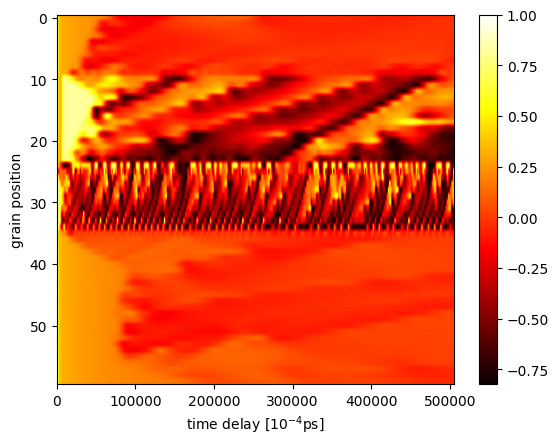

In [47]:
color_data = mag_map_man[:, :, 2].T
plt.imshow(color_data, cmap='hot', aspect='auto')
plt.ylabel(r'grain position')
plt.xlabel(r'time delay [$10^{-4}$ps]')
plt.colorbar()
plt.show()

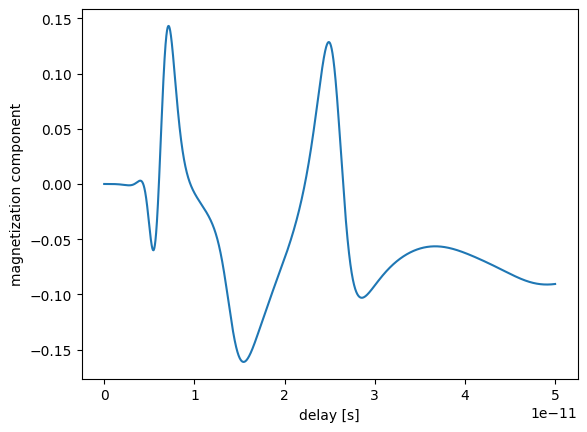

In [48]:
#plt.plot(delay, mag_map_man[:,:,2][:-1])
#plt.scatter(delay, mys)

plt.plot(delay, mag_map_man[:,0,0][:-1])
plt.xlabel(r'delay [s]')
plt.ylabel(r'magnetization component')

#plt.plot(new_delay, mag_map_man[:,0,0][:-1])
#plt.scatter(delay, mxs)

plt.show()